# Brain Tumor Detection Using a Convolutional Neural Network

In [34]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

%matplotlib inline

In [2]:
def crop_brain_contour(image, plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

In [3]:
import cv2
import os

img_path = 'yes/Y1.jpg'

# Check if file exists
print("File exists:", os.path.exists(img_path))

ex_img = cv2.imread(img_path)

if ex_img is None:
    print("⚠️ Image not loaded. Check your path!")
else:
    print("✅ Image loaded successfully with shape:", ex_img.shape)


File exists: True
✅ Image loaded successfully with shape: (218, 180, 3)


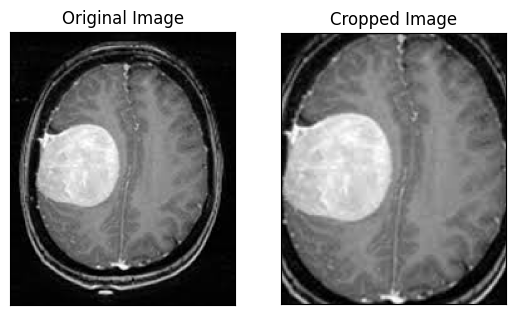

In [4]:
ex_img = cv2.imread('yes/Y1.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

### Load up the data:

The following function takes two arguments, the first one is a list of directory paths for the folders 'yes' and 'no' that contain the image data and the second argument is the image size, and for every image in both directories and does the following: 
1. Read the image.
2. Crop the part of the image representing only the brain.
3. Resize the image (because the images in the dataset come in different sizes (meaning width, height and # of channels). So, we want all of our images to be (240, 240, 3) to feed it as an input to the neural network.
4. Apply normalization because we want pixel values to be scaled to the range 0-1.
5. Append the image to <i>X</i> and its label to <i>y</i>.<br>

After that, Shuffle <i>X</i> and <i>y</i>, because the data is ordered (meaning the arrays contains the first part belonging to one class and the second part belonging to the other class, and we don't want that).<br>
Finally, Return <i>X</i> and <i>y</i>.

In [5]:
def load_data(dir_list, image_size):

    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '\\' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

Load up the data that we augmented earlier in the Data Augmentation notebook.<br>
**Note:** the augmented data directory contains not only the new generated images but also the original images.

In [6]:
augmented_path = 'augmented data/'

# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes =  'yes' 
augmented_no =  'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 253
X shape is: (253, 240, 240, 3)
y shape is: (253, 1)


As we see, we have 2065 images. Each images has a shape of **(240, 240, 3)=(image_width, image_height, number_of_channels)**

### Plot sample images:

In [7]:
def plot_sample_images(X, y, n=50):
   
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

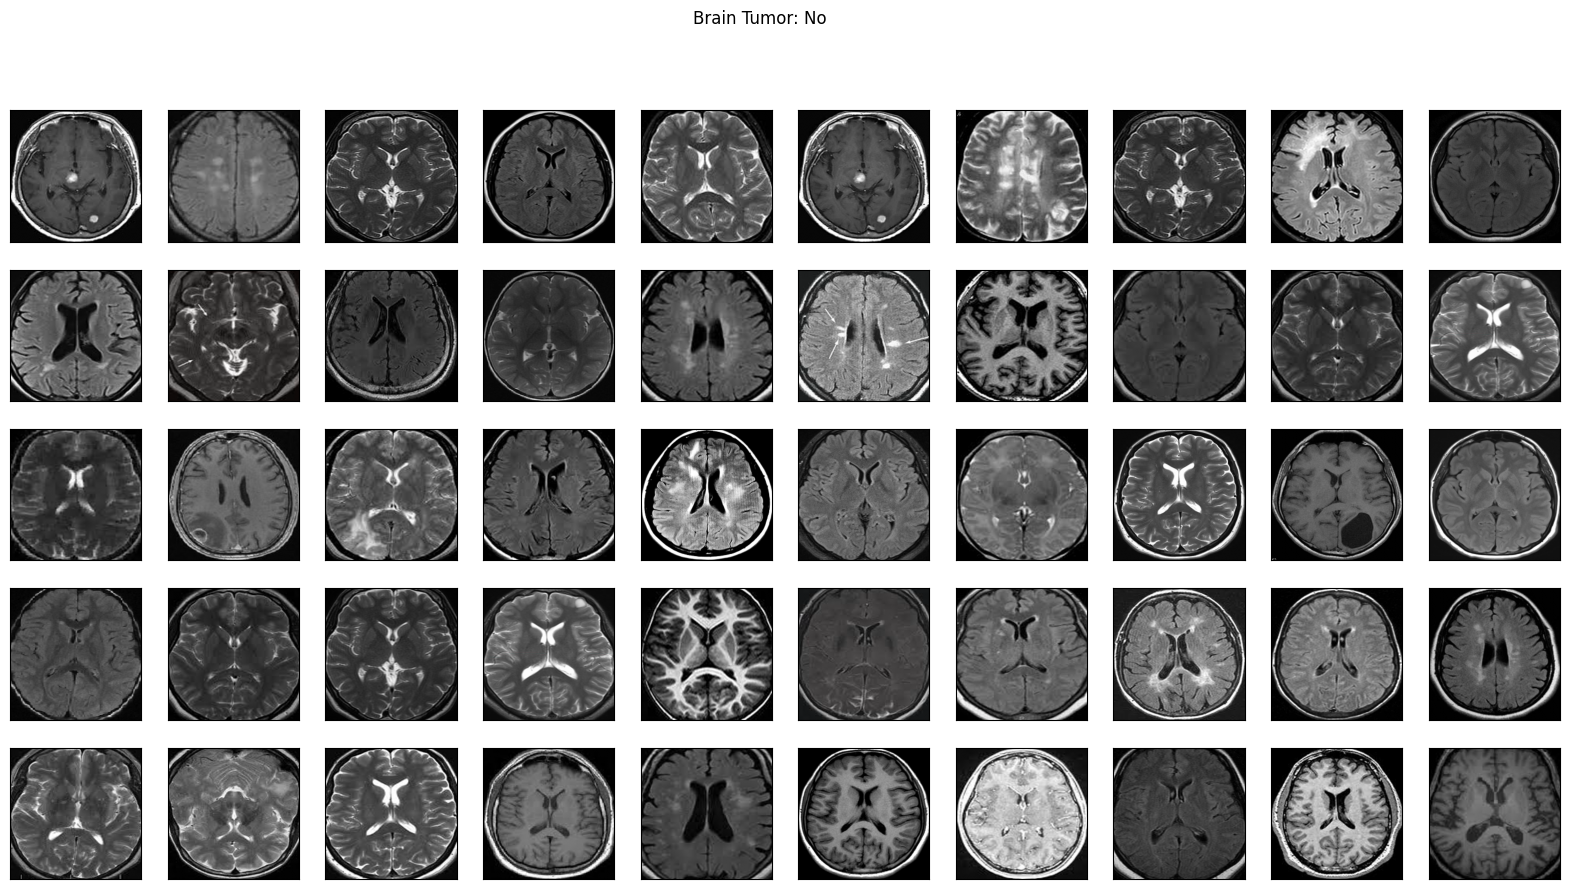

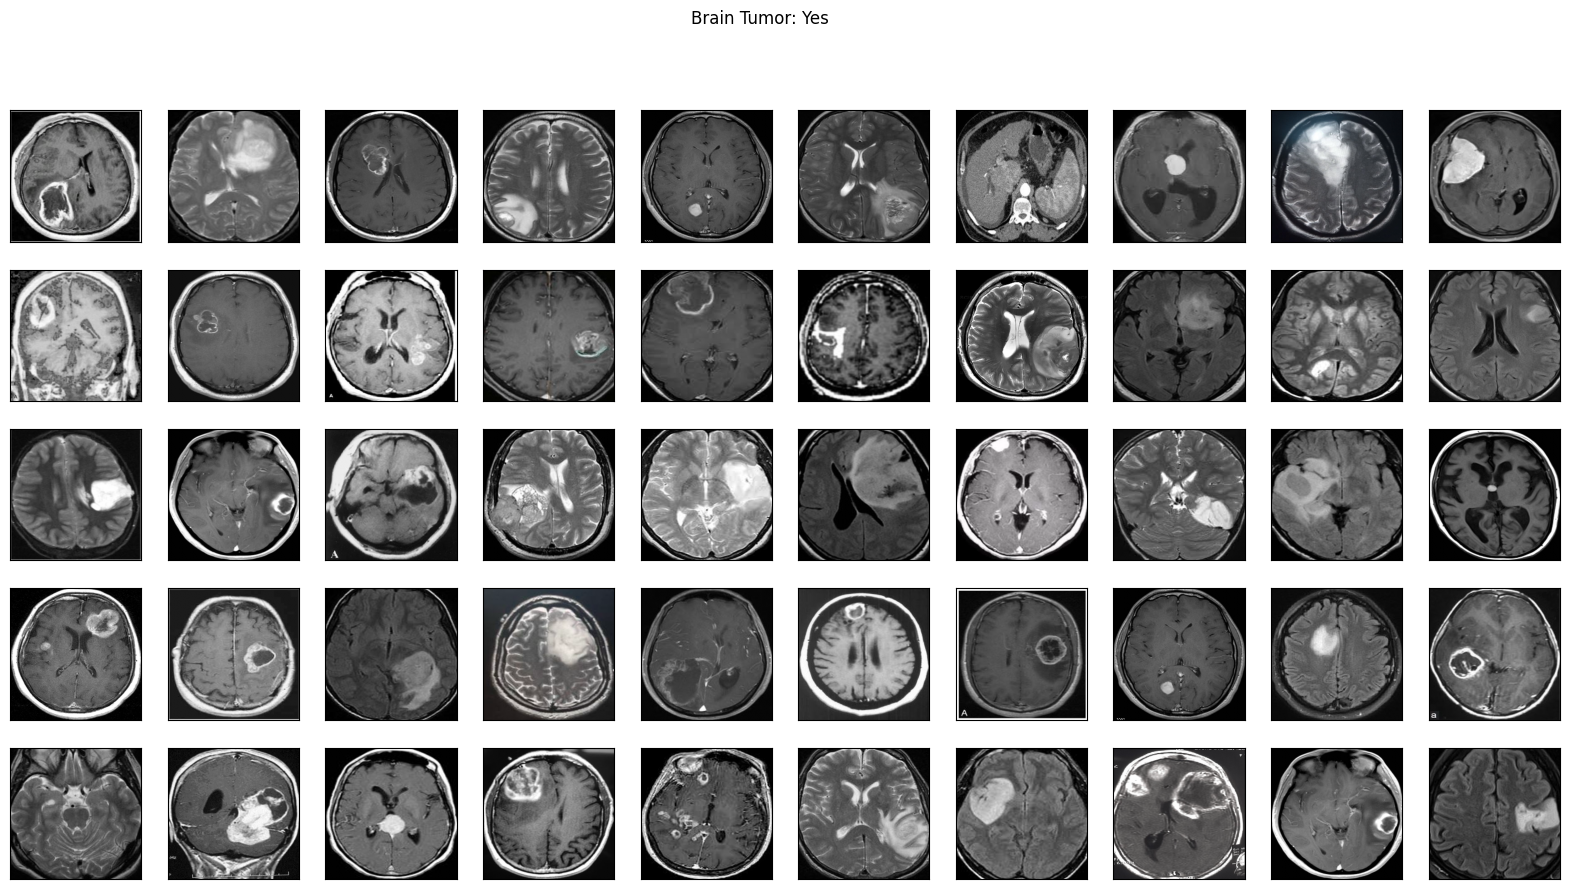

In [8]:
plot_sample_images(X, y)

### Split the data:
Split <i>X</i> and <i>y</i> into training, validation (development) and validation sets.

In [9]:
def split_data(X, y, test_size=0.2):

    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

Let's use the following way to split:<br>
1. 70% of the data for training.
2. 15% of the data for validation.
3. 15% of the data for testing.

In [10]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [11]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 177
number of development examples = 38
number of test examples = 38
X_train shape: (177, 240, 240, 3)
Y_train shape: (177, 1)
X_val (dev) shape: (38, 240, 240, 3)
Y_val (dev) shape: (38, 1)
X_test shape: (38, 240, 240, 3)
Y_test shape: (38, 1)


Some helper functions:

In [12]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [13]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

In [14]:
def build_model(input_shape):
   
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

Define the image shape:

In [15]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [16]:
model = build_model(IMG_SHAPE)

In [17]:
model.summary()

Model: "BrainDetectionModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ (None, 244, 244, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv0 (Conv2D)                  │ (None, 238, 238, 32)   │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn0 (BatchNormalization)        │ (None, 238, 238, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 238, 238, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool0 (MaxPooling2D)        │ (None, 59, 59, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool1 (MaxPooling2D)        │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc (Dense)                      │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,137 (43.50 KB)

 Trainable params: 11,073 (43.25 KB)

 Non-trainable params: 64 (256.00 B)

Compile the model:

In [18]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [19]:
# tensorboard
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [20]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint

os.makedirs('models', exist_ok=True)

filepath = "models/cnn-parameters-improvement-{epoch:02d}-{val_acc:.2f}.keras"
checkpoint = ModelCheckpoint(
    filepath=filepath,
    monitor='val_acc',        # or 'val_accuracy' depending on your metrics name
    verbose=1,
    save_best_only=True,
    mode='max'
)


## Train the model

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint
import time, os

# Create model folder if not exists
os.makedirs("models", exist_ok=True)

# Correct metric key (val_accuracy)
filepath = "models/cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}.keras"

checkpoint = ModelCheckpoint(
    filepath=filepath,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

# Train model
start_time = time.time()

history = model.fit(
    x=X_train, 
    y=y_train,
    batch_size=32,
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=[tensorboard, checkpoint]
)

end_time = time.time()
execution_time = end_time - start_time
print(f"Elapsed time: {execution_time:.2f} seconds")


Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.5702 - loss: 1.8112
Epoch 1: val_accuracy improved from None to 0.57895, saving model to models/cnn-parameters-improvement-01-0.58.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 490ms/step - accuracy: 0.5480 - loss: 2.0816 - val_accuracy: 0.5789 - val_loss: 0.6953
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.5509 - loss: 1.1334
Epoch 2: val_accuracy did not improve from 0.57895
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 428ms/step - accuracy: 0.5028 - loss: 1.0617 - val_accuracy: 0.5789 - val_loss: 0.6878
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.6730 - loss: 0.8386
Epoch 3: val_accuracy did not improve from 0.57895
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 391ms/step - accuracy: 0.6441 - loss: 0.9914 - val_accuracy: 0.5789 - val_loss: 0.7254
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.6344 - loss: 0.6854
Epoch 4: val_accuracy did not improve from 0.57895
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 391ms/step - accuracy

Let's train for a few more epochs:

In [22]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.8466 - loss: 0.3383
Epoch 1: val_accuracy did not improve from 0.68421
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 437ms/step - accuracy: 0.8927 - loss: 0.3030 - val_accuracy: 0.6579 - val_loss: 0.6339
Epoch 2/3
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.9066 - loss: 0.2948
Epoch 2: val_accuracy did not improve from 0.68421
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 353ms/step - accuracy: 0.9040 - loss: 0.2903 - val_accuracy: 0.6316 - val_loss: 0.6304
Epoch 3/3
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.9047 - loss: 0.2809
Epoch 3: val_accuracy did not improve from 0.68421
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 351ms/step - accuracy: 0.9209 - loss: 0.2574 - val_accuracy: 0.6842 - val_loss: 0.6240
Elapsed time: 0:0:7.0


In [23]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.9456 - loss: 0.2480
Epoch 1: val_accuracy did not improve from 0.68421
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 350ms/step - accuracy: 0.9435 - loss: 0.2490 - val_accuracy: 0.6842 - val_loss: 0.6183
Epoch 2/3
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.9248 - loss: 0.2424
Epoch 2: val_accuracy did not improve from 0.68421
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 338ms/step - accuracy: 0.9379 - loss: 0.2311 - val_accuracy: 0.6579 - val_loss: 0.6089
Epoch 3/3
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.9005 - loss: 0.2354
Epoch 3: val_accuracy improved from 0.68421 to 0.71053, saving model to models/cnn-parameters-improvement-03-0.71.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 378ms/step - accuracy: 0.8927 - loss: 0.2465 - val_accuracy: 0.7105 - val_loss: 0.5970
Elapsed time: 0:0:6.6


In [24]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.9381 - loss: 0.2006
Epoch 1: val_accuracy did not improve from 0.71053
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 347ms/step - accuracy: 0.9435 - loss: 0.2058 - val_accuracy: 0.7105 - val_loss: 0.6054
Epoch 2/3
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.9480 - loss: 0.2051
Epoch 2: val_accuracy did not improve from 0.71053
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 376ms/step - accuracy: 0.9492 - loss: 0.2044 - val_accuracy: 0.7105 - val_loss: 0.5883
Epoch 3/3
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.8647 - loss: 0.2956
Epoch 3: val_accuracy improved from 0.71053 to 0.73684, saving model to models/cnn-parameters-improvement-03-0.74.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 434ms/step - accuracy: 0.9096 - loss: 0.2449 - val_accuracy: 0.7368 - val_loss: 0.5821
Elapsed time: 0:0:7.1


In [25]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=5, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.9766 - loss: 0.1444
Epoch 1: val_accuracy did not improve from 0.73684
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 361ms/step - accuracy: 0.9718 - loss: 0.1533 - val_accuracy: 0.7105 - val_loss: 0.5795
Epoch 2/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.9839 - loss: 0.1519
Epoch 2: val_accuracy did not improve from 0.73684
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 382ms/step - accuracy: 0.9887 - loss: 0.1429 - val_accuracy: 0.7105 - val_loss: 0.5724
Epoch 3/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.9786 - loss: 0.1286
Epoch 3: val_accuracy did not improve from 0.73684
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 375ms/step - accuracy: 0.9831 - loss: 0.1331 - val_accuracy: 0.6579 - val_loss: 0.5718
Epoch 4/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.9817 - loss: 0.1221
Epoch 4: val_accuracy did not improve from 0.73684
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 433ms/step - accuracy: 0.9774 - loss: 0.1380 - val_accuracy: 0.6053 - val_loss: 0.5835
Epoc

In [26]:
history = model.history.history

In [27]:
for key in history.keys():
    print(key)

accuracy
loss
val_accuracy
val_loss


## Plot Loss & Accuracy

In [28]:
import matplotlib.pyplot as plt

def _get_history_dict(history):
    """Return a plain dict of lists from different history input types."""
    # If user passed a Keras History object
    if hasattr(history, "history"):
        return history.history
    # If user passed a dict already (history.history)
    if isinstance(history, dict):
        return history
    # If user passed a list of History objects or dicts -> concatenate
    if isinstance(history, (list, tuple)):
        combined = {}
        for h in history:
            d = _get_history_dict(h)
            for k, v in d.items():
                combined.setdefault(k, []).extend(v)
        return combined
    raise ValueError("Unsupported history type. Pass History, dict or list of those.")

def plot_metrics(history):
    hist = _get_history_dict(history)
    # Print available keys for debugging
    print("history keys:", list(hist.keys()))

    # possible accuracy key names
    acc_keys = ['accuracy', 'acc']
    val_acc_keys = ['val_accuracy', 'val_acc']

    # find first available key
    train_acc_key = next((k for k in acc_keys if k in hist), None)
    val_acc_key = next((k for k in val_acc_keys if k in hist), None)

    # loss keys (standard)
    train_loss_key = 'loss' if 'loss' in hist else None
    val_loss_key = 'val_loss' if 'val_loss' in hist else None

    # Build epoch range from whichever list is present (prefer accuracy, then loss)
    length_source = None
    for k in (train_acc_key, train_loss_key, val_acc_key, val_loss_key):
        if k and k in hist:
            length_source = k
            break
    if length_source is None:
        raise KeyError("No recognizable metric keys found in history (checked for accuracy/loss).")

    epochs = range(1, len(hist[length_source]) + 1)

    # Plot accuracy if available
    if train_acc_key or val_acc_key:
        plt.figure(figsize=(8,4))
        if train_acc_key:
            plt.plot(epochs, hist[train_acc_key], label='Training Accuracy')
        if val_acc_key:
            plt.plot(epochs, hist[val_acc_key], label='Validation Accuracy')
        plt.title('Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
    else:
        print("No accuracy data found; skipping accuracy plot.")

    # Plot loss if available
    if train_loss_key or val_loss_key:
        plt.figure(figsize=(8,4))
        if train_loss_key:
            plt.plot(epochs, hist[train_loss_key], label='Training Loss')
        if val_loss_key:
            plt.plot(epochs, hist[val_loss_key], label='Validation Loss')
        plt.title('Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
    else:
        print("No loss data found; skipping loss plot.")


**Note:** Since we trained the model using more than model.fit() function call, this made the history only contain the metric values of the epochs for the last call (which was for 5 epochs), so to plot the metric values across the whole process of trianing the model from the beginning, I had to grab the rest of the values. 

In [29]:
import numpy as np
from collections import Counter

# Replace with your arrays / lists
print("X_train shape:", np.shape(X_train))
print("y_train shape:", np.shape(y_train))
print("X_val   shape:", np.shape(X_val))
print("y_val   shape:", np.shape(y_val))

# Check label distributions
def count_labels(y):
    try:
        # if one-hot
        if y.ndim == 2:
            labels = np.argmax(y, axis=1)
        else:
            labels = y
    except:
        labels = np.array(y)
    return Counter(labels)

print("train label counts:", count_labels(y_train))
print("val   label counts:", count_labels(y_val))

# Check for duplicates between train & val paths (if you used file paths)
try:
    print("Number of identical examples between train and val:", len(set(map(tuple, X_train.reshape(len(X_train), -1))).intersection(
                                                                      set(map(tuple, X_val.reshape(len(X_val), -1))))))
except Exception as e:
    print("Skipping raw-image duplicate check (too large). If you used file lists, check filenames instead.")


X_train shape: (177, 240, 240, 3)
y_train shape: (177, 1)
X_val   shape: (38, 240, 240, 3)
y_val   shape: (38, 1)
train label counts: Counter({np.int64(0): 177})
val   label counts: Counter({np.int64(0): 38})
Number of identical examples between train and val: 6


In [30]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val, axis=1) if y_val.ndim==2 else y_val

print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        38

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38

[[38]]


C:\Users\rahul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


history keys: ['accuracy', 'loss', 'val_accuracy', 'val_loss']


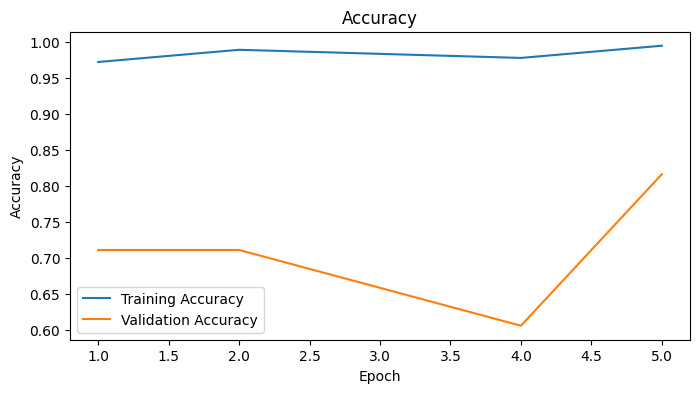

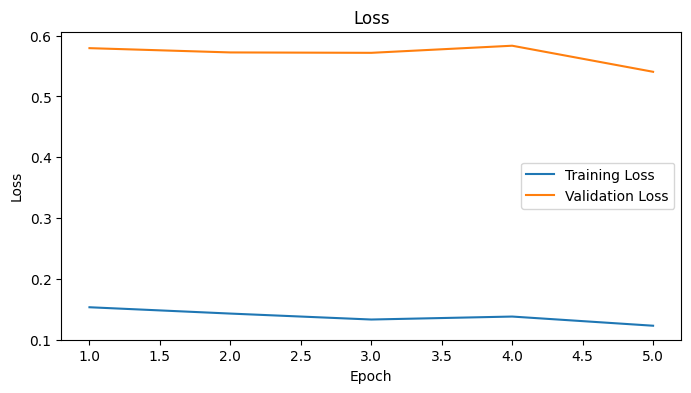

In [31]:
plot_metrics(history) 

# Results

Let's experiment with the best model (the one with the best validation accuracy):

Concretely, the model at the 23rd iteration with validation accuracy of 91%

### Load the best model

In [32]:
import os
p = 'models'
print("CWD:", os.getcwd())
print("models folder exists?", os.path.exists(p))
print("models contents:")
for f in os.listdir(p):
    print(" ", f, "->", "dir" if os.path.isdir(os.path.join(p,f)) else "file", os.path.getsize(os.path.join(p,f)))


CWD: c:\Users\rahul\Downloads\archive
models folder exists? True
models contents:
  cnn-parameters-improvement-01-0.58.keras -> file 174382
  cnn-parameters-improvement-01-0.71.keras -> file 174408
  cnn-parameters-improvement-02-0.61.keras -> file 174382
  cnn-parameters-improvement-02-0.82.keras -> file 174408
  cnn-parameters-improvement-03-0.71.keras -> file 174382
  cnn-parameters-improvement-03-0.74.keras -> file 174382
  cnn-parameters-improvement-03-0.76.keras -> file 174408
  cnn-parameters-improvement-04-0.76.keras -> file 174382
  cnn-parameters-improvement-05-0.74.keras -> file 174408
  cnn-parameters-improvement-05-0.82.keras -> file 174382
  cnn-parameters-improvement-05-0.84.keras -> file 174382
  cnn-parameters-improvement-06-0.61.keras -> file 174382
  cnn-parameters-improvement-08-0.63.keras -> file 174382
  cnn-parameters-improvement-09-0.66.keras -> file 174382
  cnn-parameters-improvement-10-0.68.keras -> file 174382


In [33]:
best_model.metrics_names

NameError: name 'best_model' is not defined

Evaluate the best model on the testing data:

In [ ]:
loss, acc = best_model.evaluate(x=X_test, y=y_test)

310/310 [==============================] - 18s 57ms/step


### Accuracy of the best model on the testing data:

In [ ]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 0.33390871454631127
Test Accuracy = 0.8870967741935484


### F1 score for the best model on the testing data:

In [ ]:
y_test_prob = best_model.predict(X_test)

In [ ]:
f1score = compute_f1_score(y_test, y_test_prob)
 print(f"F1 score: {f1score}")

F1 score: 0.8829431438127091


Let's also find the f1 score on the validation data:

In [ ]:
y_val_prob = best_model.predict(X_val)

In [ ]:
f1score_val = compute_f1_score(y_val, y_val_prob)
print(f"F1 score: {f1score_val}")

F1 score: 0.9123867069486403


### Results Interpretation

Let's remember the percentage of positive and negative examples:

In [ ]:
def data_percentage(y):
    
    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    
    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}") 



In [ ]:
# the whole data
data_percentage(y)

Number of examples: 2065
Percentage of positive examples: 52.54237288135593%, number of pos examples: 1085
Percentage of negative examples: 47.45762711864407%, number of neg examples: 980


As expectred, the percentage of positive examples are around 50%.

# Conclusion:

#### Now, the model detects brain tumor with:<br>
**88.7%** accuracy on the **test set**.<br>
**0.88** f1 score on the **test set**.<br>
These resutls are very good considering that the data is balanced.

**Performance Table:**

| <!-- -->  | Validation set | Test set |
| --------- | -------------- | -------- |
| Accuracy  | 91%            | 89%      |
| F1 score  | 0.91           | 0.88     |